# Statistical Arbitrage - Pairs Trading

In [3]:
# Import Dependencies
from cointegration_analysis import estimate_long_run_short_run_relationships, engle_granger_two_step_cointegration_test
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Data Analysis

This section visualizes our data and helps to understand, do the cointegration_analysis and display the results as well as make a selection of pairs that are cointegrated to further explore in the Algorithm section/

In [4]:
def read_data(filename):
    '''
    This function reads the .csv stored at the 'filename' location and returns a DataFrame
    with two levels of column names. The first level column contains the Stock Name and the 
    second contains the type of market data, e.g. bid/ask, price/volume.
    '''
    df = pd.read_csv(filename, index_col=0)
    df.columns = [df.columns.str[-2:], df.columns.str[:-3]]

    return df

market_data = read_data('Pairs Trading.csv')

# Show the First 5 Rows
display(market_data.head())

# Show the Stocks
stock_names = list(market_data.columns.get_level_values(0).unique())
print('The stocks available are',stock_names)

AA                                    BB            \
                 BidPrice BidVolume AskPrice AskVolume BidPrice BidVolume   
01/01/2018 00:05    80.00       135    80.25       135   100.55       105   
01/01/2018 00:10    79.95       124    80.20       145   100.50       104   
01/01/2018 00:15    79.95       124    80.15       155   100.65       100   
01/01/2018 00:20    79.95       130    80.10       154   100.75       112   
01/01/2018 00:25    79.90       121    80.10       138   100.60       126   

                                          CC            ...       MM  \
                 AskPrice AskVolume BidPrice BidVolume  ... AskPrice   
01/01/2018 00:05   100.85       105    97.85       112  ...    95.20   
01/01/2018 00:10   100.80       113    97.80       109  ...    95.20   
01/01/2018 00:15   100.95       107    97.85       110  ...    95.25   
01/01/2018 00:20   101.05       109    97.95       100  ...    95.25   
01/01/2018 00:25   100.85       124    97.95        98  ...    95.20   

                                 NN                                    OO  \
                 AskVolume BidPrice BidVolume AskPrice AskVolume BidPrice   
01/01/2018 00:05       140   137.20       122   137.60       122    88.80   
01/01/2018 00:10       144   137.20       111   137.55       110    88.75   
01/01/2018 00:15       156   137.25       117   137.65       106    88.70   
01/01/2018 00:20       153   137.25       107   137.65        97    88.75   
01/01/2018 00:25       153   137.15       111   137.60       109    88.75   

                                               
                 BidVolume AskPrice AskVolume  
01/01/2018 00:05       109    89.05       109  
01/01/2018 00:10       115    89.00       100  
01/01/2018 00:15        92    89.00       100  
01/01/2018 00:20       100    89.00       113  
01/01/2018 00:25        98    89.00       112  

[5 rows x 60 columns]

The stocks available are ['AA', 'BB', 'CC', 'DD', 'EE', 'FF', 'GG', 'HH', 'II', 'JJ', 'KK', 'LL', 'MM', 'NN', 'OO']


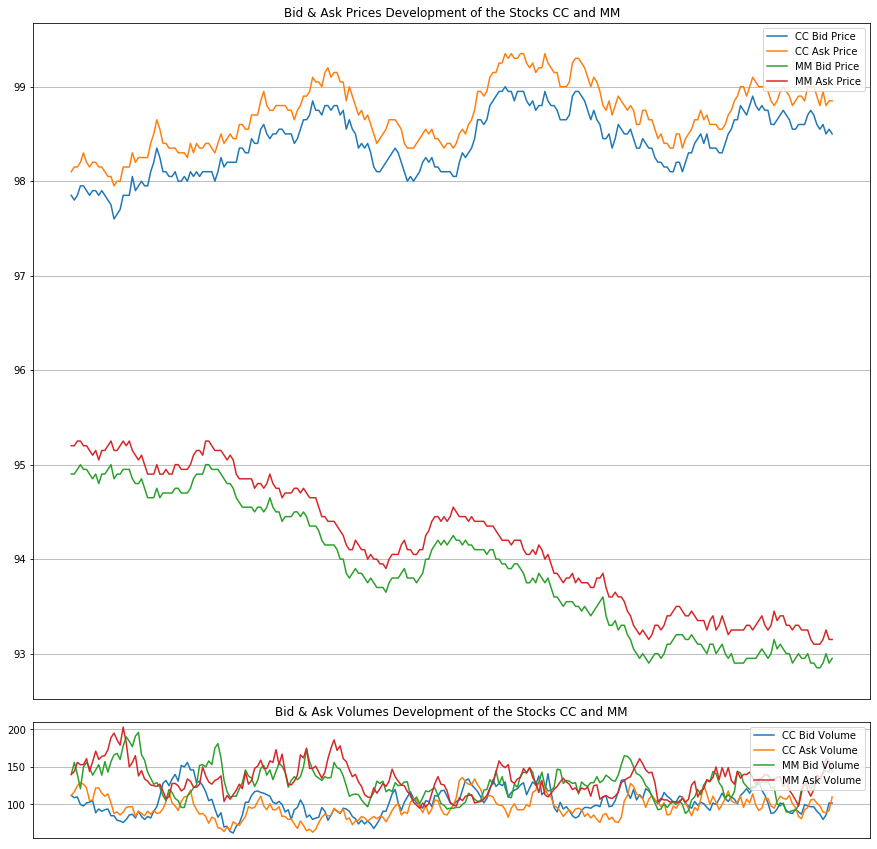

In [5]:
# Specify variable used for Plotting
market_data_segmented = market_data[:250]

# Defining Plots
def bid_ask_price_plot(stock1, stock2):
    '''
    This function creates a subplot with a specified gridsize to be able to
    effectively match it with a different subplot while still maintaining
    it's independency of being able to just show this plot.
    '''
    ax1 = plt.subplot2grid((6, 1), (0, 0), rowspan=5, colspan=1)
    plt.title('Bid & Ask Prices Development of the Stocks ' + stock1 + " and " + stock2)
    plt.grid()

    ax1.plot(market_data_segmented.index,
             market_data_segmented[stock1, 'BidPrice'])
    ax1.plot(market_data_segmented.index,
             market_data_segmented[stock1, 'AskPrice'])
    
    ax1.plot(market_data_segmented.index,
             market_data_segmented[stock2, 'BidPrice'])
    ax1.plot(market_data_segmented.index,
             market_data_segmented[stock2, 'AskPrice'])

    # We don't want to see all the timestamps
    ax1.axes.get_xaxis().set_visible(False)

    ax1.legend([stock1 + " Bid Price", stock1 + " Ask Price", stock2 + " Bid Price", stock2 + " Ask Price"], loc='upper right')

def bid_ask_volume_plot(stock1, stock2):
    '''
    This function is very similar to above's function with the exception
    of creating a smaller subplot and using different data. This function
    is meant for displaying volumes. 
    '''
    ax2 = plt.subplot2grid((6, 1), (5, 0), rowspan=1, colspan=1)
    plt.title('Bid & Ask Volumes Development of the Stocks ' + stock1 + " and " + stock2)
    plt.grid()

    ax2.plot(market_data_segmented.index,
             market_data_segmented[stock1, 'BidVolume'])
    ax2.plot(market_data_segmented.index,
             market_data_segmented[stock1, 'AskVolume'])

    ax2.plot(market_data_segmented.index,
             market_data_segmented[stock2, 'BidVolume'])
    ax2.plot(market_data_segmented.index,
             market_data_segmented[stock2, 'AskVolume'])

    # We don't want to see all the timestamps
    ax2.axes.get_xaxis().set_visible(False)

    ax2.legend([stock1 + " Bid Volume", stock1 + " Ask Volume", stock2 + " Bid Volume", stock2 + " Ask Volume"], loc='upper right')

# Show Plot
plt.figure(figsize=(15, 15))
plt.show(bid_ask_price_plot("CC", "MM"), bid_ask_volume_plot("CC", "MM"))

In [6]:
# Calculate mid-prices of each stock and add them to the DataFrame
for stock in stock_names:
    market_data[stock,'MidPrice'] = (market_data[stock,'BidPrice'] + market_data[stock,'AskPrice']) / 2
    market_data = market_data.sort_index(axis=1)
    
market_data.head()

AA                                             BB  \
                 AskPrice AskVolume BidPrice BidVolume MidPrice AskPrice   
01/01/2018 00:05    80.25       135    80.00       135   80.125   100.85   
01/01/2018 00:10    80.20       145    79.95       124   80.075   100.80   
01/01/2018 00:15    80.15       155    79.95       124   80.050   100.95   
01/01/2018 00:20    80.10       154    79.95       130   80.025   101.05   
01/01/2018 00:25    80.10       138    79.90       121   80.000   100.85   

                                                        ...       NN  \
                 AskVolume BidPrice BidVolume MidPrice  ... AskPrice   
01/01/2018 00:05       105   100.55       105  100.700  ...   137.60   
01/01/2018 00:10       113   100.50       104  100.650  ...   137.55   
01/01/2018 00:15       107   100.65       100  100.800  ...   137.65   
01/01/2018 00:20       109   100.75       112  100.900  ...   137.65   
01/01/2018 00:25       124   100.60       126  100.725  ...   137.60   

                                                             OO            \
                 AskVolume BidPrice BidVolume MidPrice AskPrice AskVolume   
01/01/2018 00:05       122   137.20       122  137.400    89.05       109   
01/01/2018 00:10       110   137.20       111  137.375    89.00       100   
01/01/2018 00:15       106   137.25       117  137.450    89.00       100   
01/01/2018 00:20        97   137.25       107  137.450    89.00       113   
01/01/2018 00:25       109   137.15       111  137.375    89.00       112   

                                              
                 BidPrice BidVolume MidPrice  
01/01/2018 00:05    88.80       109   88.925  
01/01/2018 00:10    88.75       115   88.875  
01/01/2018 00:15    88.70        92   88.850  
01/01/2018 00:20    88.75       100   88.875  
01/01/2018 00:25    88.75        98   88.875  

[5 rows x 75 columns]

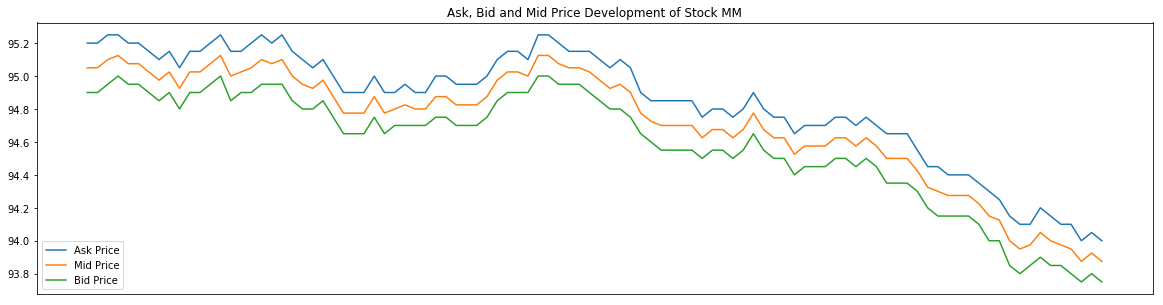

In [7]:
def mid_price_check(stock):
    '''
    Function that checks for different stocks if the MidPrice
    is correctly specified.
    '''
    plt.figure(figsize=(20, 5))
    plt.plot(market_data[stock,'AskPrice'][:100])
    plt.plot(market_data[stock,'MidPrice'][:100])
    plt.plot(market_data[stock,'BidPrice'][:100])

    plt.xticks([]) # Timestamp is not Important
    plt.title('Ask, Bid and Mid Price Development of Stock ' + stock)
    plt.legend(["Ask Price", "Mid Price", "Bid Price"], loc='lower left')
    plt.show()
    
mid_price_check('MM')

In [8]:
# Obtain the statistical parameters for each and every pair
data_analysis = {'Pairs': [],
                 'Constant': [],
                 'Gamma': [],
                 'Alpha': [],
                 'P-Value': []}

data_zvalues = {}

for stock1 in stock_names:
    for stock2 in stock_names:
        if stock1 != stock2:
            if (stock2, stock1) in data_analysis['Pairs']:
                continue

            pairs = stock1, stock2
            constant = estimate_long_run_short_run_relationships(np.log(
                market_data[stock1, 'MidPrice']), np.log(market_data[stock2, 'MidPrice']))[0]
            gamma = estimate_long_run_short_run_relationships(np.log(
                market_data[stock1, 'MidPrice']), np.log(market_data[stock2, 'MidPrice']))[1]
            alpha = estimate_long_run_short_run_relationships(np.log(
                market_data[stock1, 'MidPrice']), np.log(market_data[stock2, 'MidPrice']))[2]
            pvalue = engle_granger_two_step_cointegration_test(np.log(
                market_data[stock1, 'MidPrice']), np.log(market_data[stock2, 'MidPrice']))[1]
            zvalue = estimate_long_run_short_run_relationships(np.log(
                market_data[stock1, 'MidPrice']), np.log(market_data[stock2, 'MidPrice']))[3]

            data_analysis['Pairs'].append(pairs)
            data_analysis['Constant'].append(constant)
            data_analysis['Gamma'].append(gamma)
            data_analysis['Alpha'].append(alpha)
            data_analysis['P-Value'].append(pvalue)

            data_zvalues[pairs] = zvalue
            
data_analysis = round(pd.DataFrame(data_analysis),4).set_index('Pairs')

C:\Users\jerbo\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


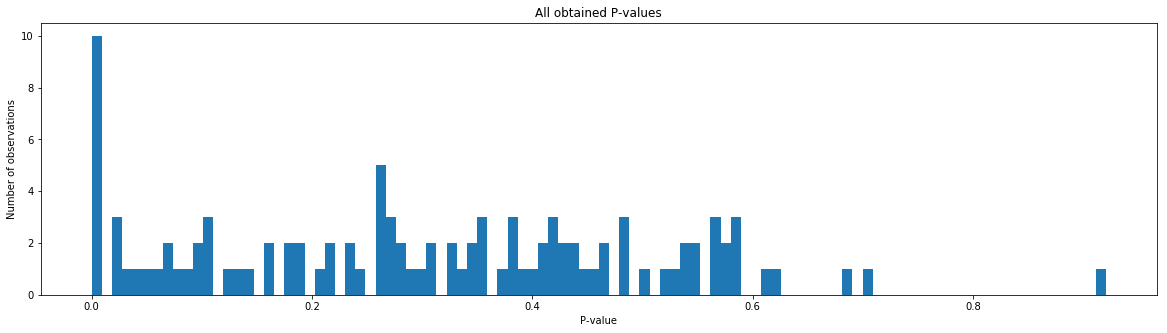

In [9]:
# Visualize the P-values
def plot_pvalues():
    """
    This function plots all obtained P-values.
    """
    plt.figure(figsize=(20, 5))
    plt.hist(data_analysis['P-Value'], bins=100)
    plt.xlabel('P-value')
    plt.ylabel('Number of observations')
    plt.title('All obtained P-values')
    plt.show()

plot_pvalues()

In [10]:
# Show Top 10 and Bottom 10
display(data_analysis.sort_values('P-Value')[:10])
display(data_analysis.sort_values('P-Value')[-10:])

,Constant,Gamma,Alpha,P-Value
Pairs,,,,
"(FF, NN)",-2.6104,1.4881,-0.0022,0.0000
"(FF, MM)",0.3061,0.9676,-0.0338,0.0000
"(BB, DD)",-2.4182,1.4758,-0.0075,0.0000
"(DD, HH)",-1.6797,1.2787,-0.0040,0.0000
"(BB, JJ)",-2.4809,1.6206,-0.0000,0.0000
"(DD, JJ)",0.2277,1.0356,0.0002,0.0000
"(MM, NN)",-2.9034,1.5153,-0.0002,0.0000
"(BB, HH)",-4.8181,1.8712,-0.0024,0.0009
"(HH, JJ)",1.9492,0.7041,-0.0002,0.0010


,Constant,Gamma,Alpha,P-Value
Pairs,,,,
"(AA, BB)",4.2082,0.0571,-0.0001,0.5739
"(EE, JJ)",5.0700,-0.0369,-0.0002,0.5765
"(AA, MM)",10.2964,-1.2938,-0.0001,0.5812
"(AA, KK)",9.7238,-1.1233,-0.0001,0.5826
"(AA, JJ)",4.1324,0.0773,-0.0001,0.5860
"(AA, DD)",4.2125,0.0540,-0.0001,0.6103
"(CC, EE)",1.7955,0.5551,-0.0002,0.6199
"(CC, OO)",8.4182,-0.8627,-0.0002,0.6888
"(CC, GG)",2.8739,0.3184,-0.0002,0.7055


In [11]:
# Selecting tradable pairs where P-Value < 0.01 and create a seperate DataFrame containing these pairs
tradable_pairs_analysis = data_analysis[data_analysis['P-Value'] < 0.01].sort_values('P-Value')

tradable_pairs_analysis

,Constant,Gamma,Alpha,P-Value
Pairs,,,,
"(BB, DD)",-2.4182,1.4758,-0.0075,0.0000
"(BB, JJ)",-2.4809,1.6206,-0.0000,0.0000
"(DD, HH)",-1.6797,1.2787,-0.0040,0.0000
"(DD, JJ)",0.2277,1.0356,0.0002,0.0000
"(FF, MM)",0.3061,0.9676,-0.0338,0.0000
"(FF, NN)",-2.6104,1.4881,-0.0022,0.0000
"(MM, NN)",-2.9034,1.5153,-0.0002,0.0000
"(BB, HH)",-4.8181,1.8712,-0.0024,0.0009
"(HH, JJ)",1.9492,0.7041,-0.0002,0.0010


In [12]:
# Get all the tradable stock pairs into a list
stock_pairs = list(tradable_pairs_analysis.index.values.tolist())

# Show the Pairs
stock_pairs

[('BB', 'DD'),
 ('BB', 'JJ'),
 ('DD', 'HH'),
 ('DD', 'JJ'),
 ('FF', 'MM'),
 ('FF', 'NN'),
 ('MM', 'NN'),
 ('BB', 'HH'),
 ('HH', 'JJ'),
 ('AA', 'II')]

# Algorithm

Within this section we build further on the Data Analysis section by zooming in onto the pairs and calculate additional data on the error correction terms.

In [13]:
# Create a list of unique tradable stocks
list_stock1 = [stock[0] for stock in stock_pairs]
list_stock2 = [stock[1] for stock in stock_pairs]

for stock in list_stock2:
    list_stock1.append(stock)
    
unique_stock_list = list(set(list_stock1))

# Create a new DataFrame containing all market information for the tradable pairs
tradable_pairs_data = market_data[unique_stock_list]
tradable_pairs_data.head()

JJ                                             AA  \
                 AskPrice AskVolume BidPrice BidVolume MidPrice AskPrice   
01/01/2018 00:05    80.05       156    79.80       156   79.925    80.25   
01/01/2018 00:10    80.00       161    79.75       157   79.875    80.20   
01/01/2018 00:15    79.90       145    79.65       152   79.775    80.15   
01/01/2018 00:20    79.95       140    79.65       154   79.800    80.10   
01/01/2018 00:25    79.95       137    79.65       158   79.800    80.10   

                                                        ...       DD  \
                 AskVolume BidPrice BidVolume MidPrice  ... AskPrice   
01/01/2018 00:05       135    80.00       135   80.125  ...   117.30   
01/01/2018 00:10       145    79.95       124   80.075  ...   117.25   
01/01/2018 00:15       155    79.95       124   80.050  ...   117.20   
01/01/2018 00:20       154    79.95       130   80.025  ...   117.30   
01/01/2018 00:25       138    79.90       121   80.000  ...   117.30   

                                                             BB            \
                 AskVolume BidPrice BidVolume MidPrice AskPrice AskVolume   
01/01/2018 00:05       102   116.95       102  117.125   100.85       105   
01/01/2018 00:10       103   116.95        98  117.100   100.80       113   
01/01/2018 00:15       113   116.90       109  117.050   100.95       107   
01/01/2018 00:20       117   116.95       100  117.125   101.05       109   
01/01/2018 00:25       129   116.95       106  117.125   100.85       124   

                                              
                 BidPrice BidVolume MidPrice  
01/01/2018 00:05   100.55       105  100.700  
01/01/2018 00:10   100.50       104  100.650  
01/01/2018 00:15   100.65       100  100.800  
01/01/2018 00:20   100.75       112  100.900  
01/01/2018 00:25   100.60       126  100.725  

[5 rows x 45 columns]

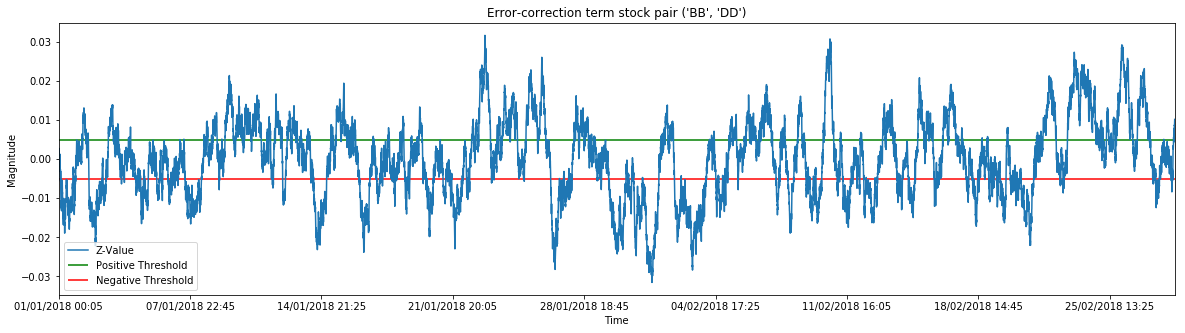

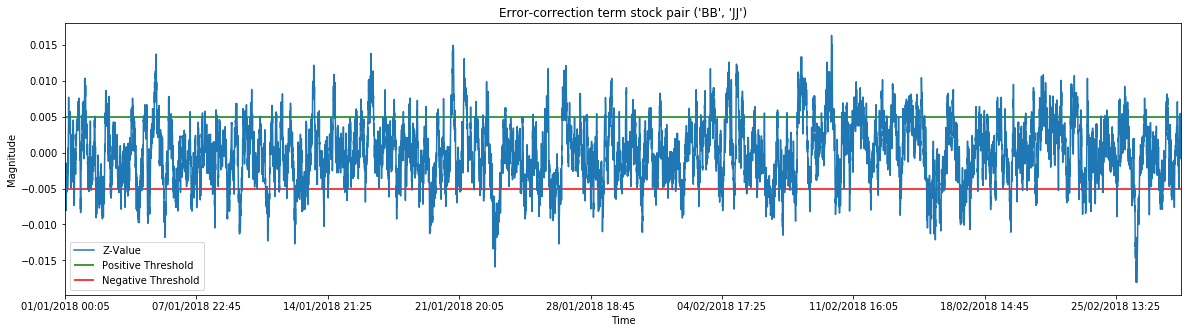

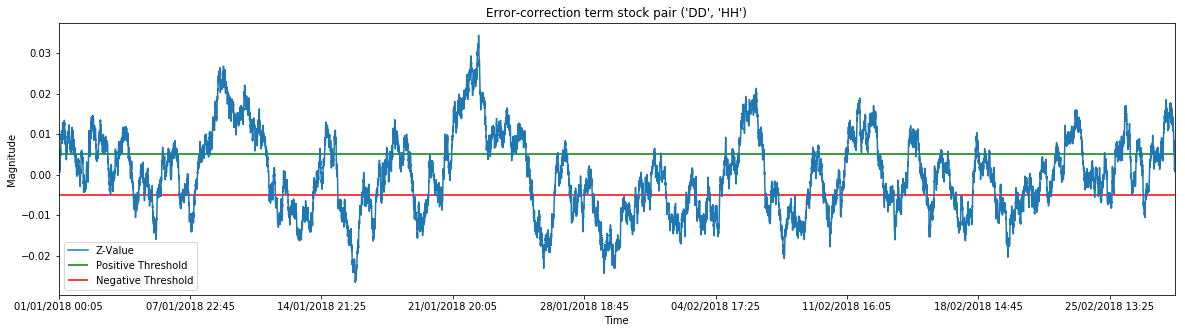

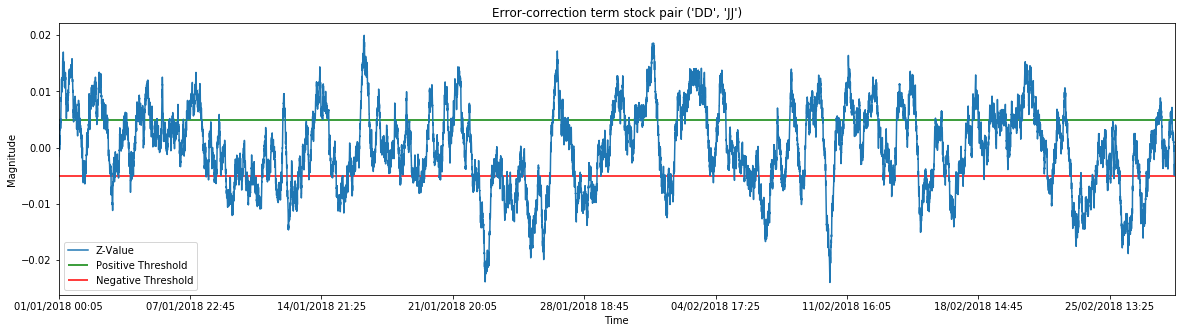

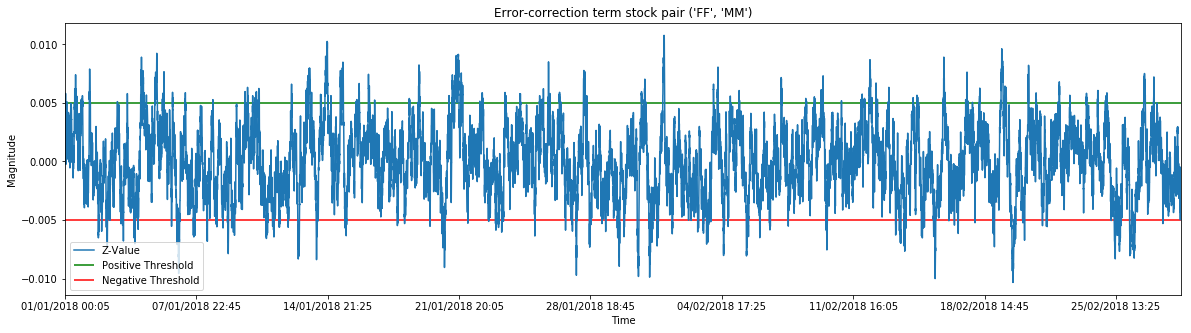

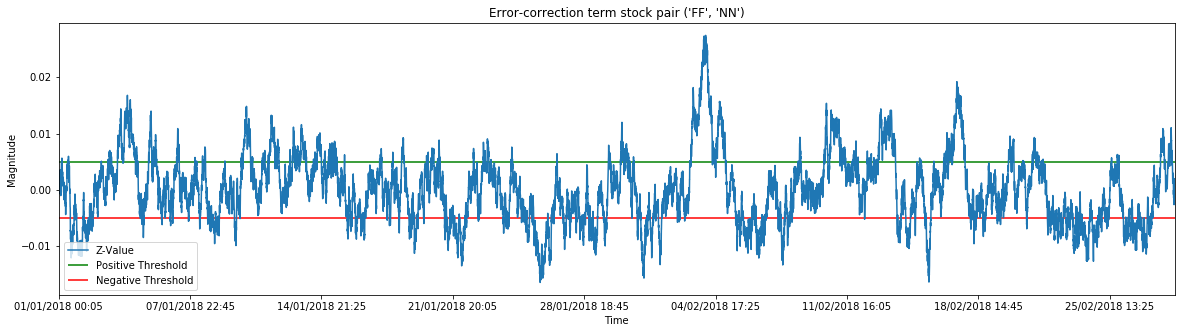

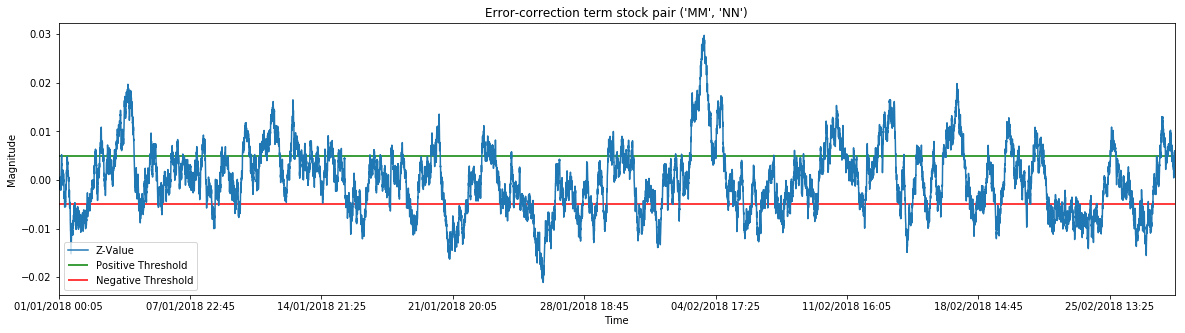

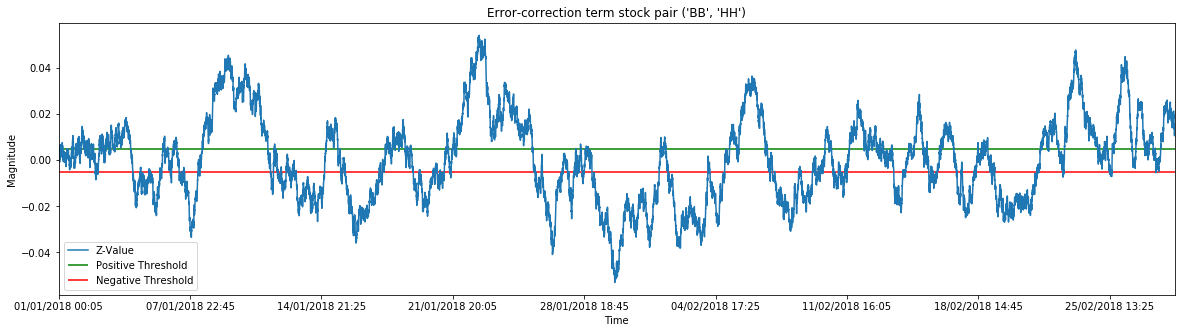

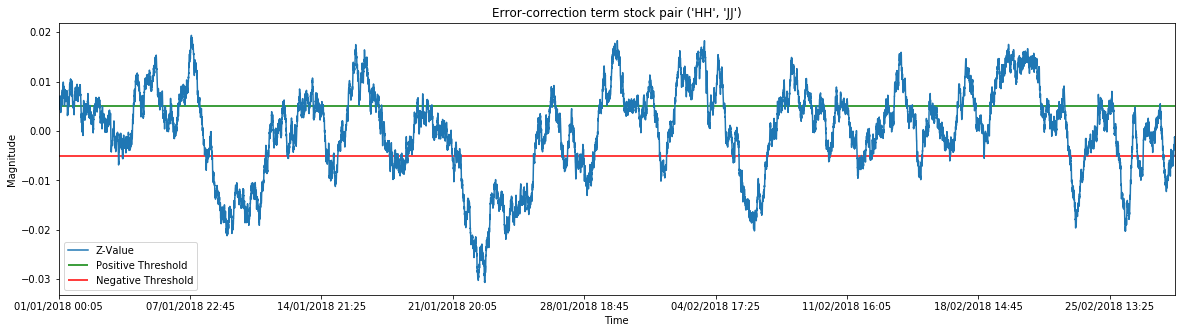

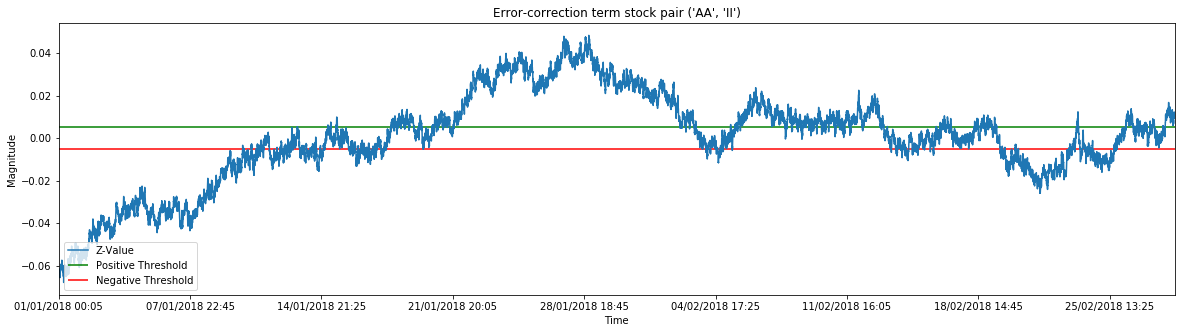

In [14]:
def Plot_Tradable_Z():
    """
    This function plots the z-values of all pairs based on
    the data_zvalues dataframe.
    """
    for pair in stock_pairs: 
        zvalue = data_zvalues[pair]
        plt.figure(figsize=(20,5))
        plt.title('Error-correction term stock pair {}'.format(pair))
        zvalue.plot()
        plt.xlabel('Time')
        plt.ylabel('Magnitude')

        xmin = 0
        xmax = len(zvalue)
        plt.hlines(0.005, xmin, xmax, 'g') # Note 0.005 is randomly chosen
        plt.hlines(-0.005, xmin, xmax, 'r') # Note -0.005 is randomly chosen
        
        plt.legend(['Z-Value', 'Positive Threshold', 'Negative Threshold'], loc='lower left')
        
        plt.show()
        
Plot_Tradable_Z()

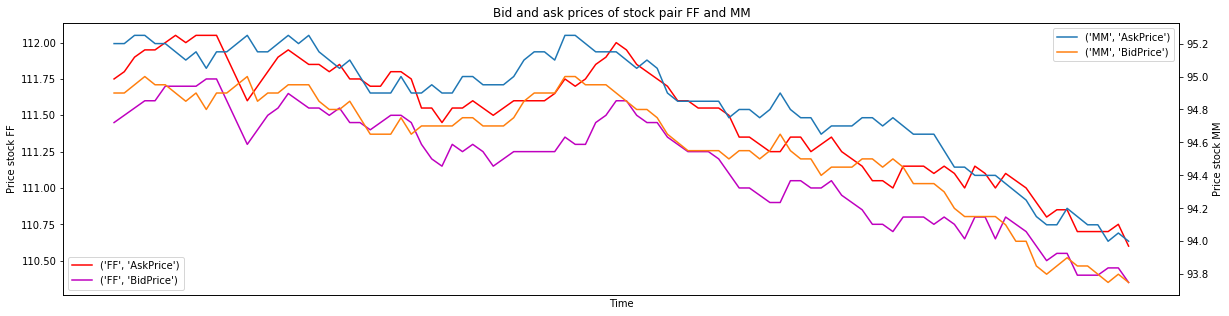

In [15]:
# Select randomly chosen pair from the tradable stock and visualize bid and ask prices, bid and ask volumes, and the z-values
import random

# Choose random stock
random_pair = random.choice(stock_pairs)

# Create a plot showing the bid and ask prices of a randomly chosen stock
def Plot_RandomPair_BidAskPrices():
    """
    This function plots the bid and ask price of a randomly chosen tradable pair.
    """
    plt.figure(figsize=(20,5))
    plt.title('Bid and ask prices of stock pair {} and {}'.format(random_pair[0], random_pair[1]))
    
    plt.plot(tradable_pairs_data[random_pair[0], 'AskPrice'].iloc[:100], 'r')
    plt.plot(tradable_pairs_data[random_pair[0], 'BidPrice'].iloc[:100], 'm')
    plt.xlabel('Time')
    plt.ylabel('Price stock {}'.format(random_pair[0]))
    plt.legend(loc='lower left')
    
    plt.twinx()
    plt.plot(tradable_pairs_data[random_pair[1], 'AskPrice'].iloc[:100])
    plt.plot(tradable_pairs_data[random_pair[1], 'BidPrice'].iloc[:100])
    plt.xticks([])
    plt.ylabel('Price stock {}'.format(random_pair[1]))
    plt.legend(loc='upper right')
    
    plt.show()

Plot_RandomPair_BidAskPrices()

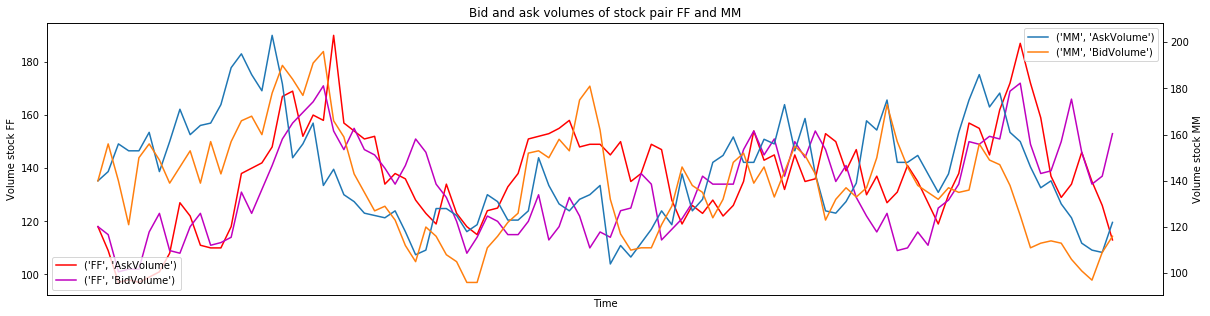

In [16]:
# Create a plot showing the bid and ask volumes of a randomly chosen stock
def Plot_RandomPair_BidAskVolumes(): # Plot not really clarifying, maybe other kind of plot?
    """
    This function plots the bid and ask volumes of a randomly chosen tradable pair.
    """
    plt.figure(figsize=(20,5))
    plt.title('Bid and ask volumes of stock pair {} and {}'.format(random_pair[0],random_pair[1]))
    
    plt.plot(tradable_pairs_data[random_pair[0], 'AskVolume'].iloc[:100], 'r')
    plt.plot(tradable_pairs_data[random_pair[0], 'BidVolume'].iloc[:100], 'm')
    plt.xlabel('Time')
    plt.ylabel('Volume stock {}'.format(random_pair[0]))
    plt.legend(loc='lower left')
    
    plt.twinx()
    plt.plot(tradable_pairs_data[random_pair[1], 'AskVolume'].iloc[:100])
    plt.plot(tradable_pairs_data[random_pair[1], 'BidVolume'].iloc[:100])
    plt.xticks([])
    plt.ylabel('Volume stock {}'.format(random_pair[1]))
    plt.legend(loc='upper right')
    
    plt.show()

Plot_RandomPair_BidAskVolumes()

In [17]:
# Create a Dataframe containing information about the error-correction term of each pair
data_error_correction_term = {'Pair': [],
                              'CountZeroCrossings': [],
                              'TradingPeriod': [],
                              'LongRunMean': [],
                              'Std': []}

for pair in stock_pairs:
    zvalue = data_zvalues[pair]
    my_array = np.array(zvalue)
    count = ((my_array[:-1] * my_array[1:]) < 0).sum()
    trading_period = 1 / count
    long_run_mean = zvalue.mean()
    std = zvalue.std()

    data_error_correction_term['Pair'].append(pair)
    data_error_correction_term['CountZeroCrossings'].append(count)
    data_error_correction_term['TradingPeriod'].append(trading_period)
    data_error_correction_term['LongRunMean'].append(round(long_run_mean, 4))
    data_error_correction_term['Std'].append(round(std, 4))

data_error_correction_term = pd.DataFrame(data_error_correction_term).set_index('Pair')

data_error_correction_term

,CountZeroCrossings,TradingPeriod,LongRunMean,Std
Pair,,,,
"(BB, DD)",660,0.001515,-0.0,0.0100
"(BB, JJ)",1475,0.000678,-0.0,0.0044
"(DD, HH)",396,0.002525,-0.0,0.0097
"(DD, JJ)",592,0.001689,0.0,0.0072
"(FF, MM)",1413,0.000708,0.0,0.0031
"(FF, NN)",705,0.001418,-0.0,0.0061
"(MM, NN)",627,0.001595,0.0,0.0068
"(BB, HH)",334,0.002994,0.0,0.0181
"(HH, JJ)",363,0.002755,-0.0,0.0090


## Threshold Analysis for All Stock Pairs

This section is for discovering what treshold would maximize profits for a given pair. We did many loops over different thresholds to find the ideal level. In the next section, the pairs with the highest profits those that are unique (prevent having a stock as 'BB' be traded twice) will be picked to determine the final profit

In [18]:
# Create a new column within the earlier defined DataFrame with Z-Values of all stock pairs
for pair in stock_pairs:
    stock1 = pair[0]
    stock2 = pair[1]
    
    tradable_pairs_data[stock1+stock2, 'Z-Value'] = data_zvalues[stock1,stock2]

C:\Users\jerbo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [19]:
# Create a Dictionary that saves all Gamma values of each pair
gamma_dictionary = {}

for pair, value in tradable_pairs_analysis.iterrows():
    gamma_dictionary[pair]= value['Gamma']
    
gamma_dictionary

{('BB', 'DD'): 1.4758,
 ('BB', 'JJ'): 1.6206,
 ('DD', 'HH'): 1.2787,
 ('DD', 'JJ'): 1.0356,
 ('FF', 'MM'): 0.9676,
 ('FF', 'NN'): 1.4881,
 ('MM', 'NN'): 1.5153,
 ('BB', 'HH'): 1.8712,
 ('HH', 'JJ'): 0.7041,
 ('AA', 'II'): 0.9944}

In [20]:
# Create a Dictionary that saves all Standard Deviation values of each pair
std_dictionary = {}

for pair, value in data_error_correction_term.iterrows():
    std_dictionary[pair]= value['Std']
    
std_dictionary

{('BB', 'DD'): 0.01,
 ('BB', 'JJ'): 0.0044,
 ('DD', 'HH'): 0.0097,
 ('DD', 'JJ'): 0.0072,
 ('FF', 'MM'): 0.0031,
 ('FF', 'NN'): 0.0061,
 ('MM', 'NN'): 0.0068,
 ('BB', 'HH'): 0.0181,
 ('HH', 'JJ'): 0.009,
 ('AA', 'II'): 0.0214}

This is our Algorithm for finding the correct thresholds that are able to generate the greatest amount of profit. We find it important to <b>not</b> <i>maximize</i> the profit because what holds for historic data is not guaranteed to hold for future data. We therefore specify a limited selection of thresholds with a linspace.

In [21]:
positions = {}
limit = 100

for pair in stock_pairs:
    stock1 = pair[0]
    stock2 = pair[1]
    
    gamma = gamma_dictionary[stock1,stock2]
    
    for i in np.linspace(0.05, 1.0, 10):
        threshold = i * std_dictionary[stock1,stock2]
        
        current_position_stock1 = 0 
        current_position_stock2 = 0 
        
        column_name_stock1 = stock1 + ' Pos - Thres: ' + str(threshold)
        
        BidPrice_Stock1 = tradable_pairs_data[stock1,'BidVolume'][0]
        AskPrice_Stock1 = tradable_pairs_data[stock1,'AskVolume'][0]
        BidPrice_Stock2 = tradable_pairs_data[stock2,'BidVolume'][0]
        AskPrice_Stock2 = tradable_pairs_data[stock1,'AskVolume'][0]
        
        positions[column_name_stock1] = []
        
        for time, data_at_time in tradable_pairs_data.iterrows():
            
            BidVolume_Stock1 = data_at_time[stock1, 'BidVolume']
            AskVolume_Stock1 = data_at_time[stock1, 'AskVolume']
            BidVolume_Stock2 = data_at_time[stock2, 'BidVolume']
            AskVolume_Stock2 = data_at_time[stock2, 'AskVolume']
            
            zvalue = data_at_time[stock1+stock2,'Z-Value']

            # If the zvalues of (BB,DD) are high the spread diverges, i.e. sell BB (=stock1=y) and buy DD (=stock2=x)
            if zvalue >= threshold:
                hedge_ratio = gamma * (BidPrice_Stock1 / AskPrice_Stock2)
                
                if hedge_ratio >= 1:

                    max_order_stock1 = current_position_stock1 + limit
                    max_order_stock2 = max_order_stock1 / hedge_ratio

                    trade = np.floor(min((BidVolume_Stock1 / hedge_ratio), AskVolume_Stock2, max_order_stock1, max_order_stock2))

                    positions[column_name_stock1].append((- trade * hedge_ratio) + current_position_stock1)

                    current_position_stock1 = ((- trade * hedge_ratio) + current_position_stock1)
                
                elif hedge_ratio < 1:

                    max_order_stock1 = current_position_stock1 + limit
                    max_order_stock2 = max_order_stock1 * hedge_ratio

                    trade = np.floor(min((BidVolume_Stock1 * hedge_ratio), AskVolume_Stock2, max_order_stock1, max_order_stock2))

                    positions[column_name_stock1].append((- trade / hedge_ratio) + current_position_stock1)

                    current_position_stock1 = ((- trade / hedge_ratio) + current_position_stock1)

            elif zvalue <= -threshold:
                hedge_ratio = gamma * (AskPrice_Stock1 / BidPrice_Stock2)
                
                if hedge_ratio >= 1:

                    max_order_stock1 = abs(current_position_stock1 - limit)
                    max_order_stock2 = max_order_stock1 / hedge_ratio

                    trade = np.floor(min((AskVolume_Stock1 / hedge_ratio), BidVolume_Stock2, max_order_stock1, max_order_stock2))

                    positions[column_name_stock1].append((+ trade * hedge_ratio) + current_position_stock1)

                    current_position_stock1 = (+ trade * hedge_ratio) + current_position_stock1

                elif hedge_ratio < 1:
                    
                    max_order_stock1 = abs(current_position_stock1 - limit)
                    max_order_stock2 = max_order_stock1 * hedge_ratio

                    trade = np.floor(min((AskVolume_Stock1 * hedge_ratio), BidVolume_Stock2, max_order_stock1, max_order_stock2))

                    positions[column_name_stock1].append((+ trade / hedge_ratio) + current_position_stock1)

                    current_position_stock1 = (+ trade / hedge_ratio) + current_position_stock1  
                
                BidPrice_Stock1 = data_at_time[stock1, 'BidPrice']
                AskPrice_Stock1 = data_at_time[stock1, 'AskPrice']
                BidPrice_Stock2 = data_at_time[stock2, 'BidPrice']
                AskPrice_Stock2 = data_at_time[stock2, 'AskPrice']

            else:
                    positions[column_name_stock1].append(current_position_stock1)
        
        column_name_stock2 = stock2 + ' Pos - Thres: ' + str(threshold)
        
        if hedge_ratio >= 1:
            positions[column_name_stock2] = positions[column_name_stock1] / hedge_ratio * -1
        
        elif hedge_ratio < 1:
            positions[column_name_stock2] = positions[column_name_stock1] / (1 / hedge_ratio) * -1

In [22]:
# Create a seperate dataframe (to keep the original dataframe intact) with rounding
# Also insert the timestamp, as found in the tradeable_pairs_data DataFrame
positions_final = np.ceil(pd.DataFrame(positions))
positions_final['Timestamp'] = tradable_pairs_data.index
positions_final = positions_final.set_index('Timestamp')

In [23]:
# The difference between the positions
positions_diff = positions_final.diff()[1:]

# Positions_diff first rows
positions_diff.head()

# OPTIONAL to Excel to Save the Amount of Trades
# positions_diff[(positions_diff != 0)].count().to_excel('Thresholds.xlsx')

,BB Pos - Thres: 0.0005,DD Pos - Thres: 0.0005,BB Pos - Thres: 0.0015555555555555557,DD Pos - Thres: 0.0015555555555555557,BB Pos - Thres: 0.0026111111111111114,DD Pos - Thres: 0.0026111111111111114,BB Pos - Thres: 0.0036666666666666666,DD Pos - Thres: 0.0036666666666666666,BB Pos - Thres: 0.004722222222222222,DD Pos - Thres: 0.004722222222222222,...,AA Pos - Thres: 0.012364444444444445,II Pos - Thres: 0.012364444444444445,AA Pos - Thres: 0.014623333333333334,II Pos - Thres: 0.014623333333333334,AA Pos - Thres: 0.016882222222222222,II Pos - Thres: 0.016882222222222222,AA Pos - Thres: 0.019141111111111112,II Pos - Thres: 0.019141111111111112,AA Pos - Thres: 0.0214,II Pos - Thres: 0.0214
Timestamp,,,,,,,,,,,,,,,,,,,,,
01/01/2018 00:10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01/01/2018 00:15,0.0,0.0,-98.0,80.0,-98.0,80.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01/01/2018 00:20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01/01/2018 00:25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01/01/2018 00:30,132.0,-106.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


This method is used to value our last position by the correct market value. This to ensure that in the time between our last trade and the last timestamp does not hold any secrets (a market crash for example) that are not calculated in the PnL. One could say the profit is for example €50.000 while it is actually far lower because our positions are worth next to nothing due to a market crash.

In [24]:
positions_diff[-1:] = -positions_final[-1:]

To determine which threshold is the most profitable, we determine the PnL of each combination of pair and threshold. 

In [25]:
pnl_dataframe = pd.DataFrame()

for pair in stock_pairs:
    stock1 = pair[0]
    stock2 = pair[1]

    Stock1_AskPrice = tradable_pairs_data[stock1, 'AskPrice'][1:]
    Stock1_BidPrice = tradable_pairs_data[stock1, 'BidPrice'][1:]
    Stock2_AskPrice = tradable_pairs_data[stock2, 'AskPrice'][1:]
    Stock2_BidPrice = tradable_pairs_data[stock2, 'BidPrice'][1:]

    for i in np.linspace(0.05, 1.0, 10):
        threshold = i * std_dictionary[stock1, stock2]

        column_name_1 = stock1 + ' Pos - Thres: ' + str(threshold)
        column_name_2 = stock2 + ' Pos - Thres: ' + str(threshold)

        pnl_dataframe[stock1 + str(threshold)] = np.where(positions_diff[column_name_1] > 0,
                                                          positions_diff[column_name_1] * -Stock1_BidPrice, positions_diff[column_name_1] * -Stock1_AskPrice)
        pnl_dataframe[stock2 + str(threshold)] = np.where(positions_diff[column_name_2] > 0,
                                                          positions_diff[column_name_2] * -Stock2_BidPrice, positions_diff[column_name_2] * -Stock2_AskPrice)

pnl_dataframe.head()

,BB0.0005,DD0.0005,BB0.0015555555555555557,DD0.0015555555555555557,BB0.0026111111111111114,DD0.0026111111111111114,BB0.0036666666666666666,DD0.0036666666666666666,BB0.004722222222222222,DD0.004722222222222222,...,AA0.012364444444444445,II0.012364444444444445,AA0.014623333333333334,II0.014623333333333334,AA0.016882222222222222,II0.016882222222222222,AA0.019141111111111112,II0.019141111111111112,AA0.0214,II0.0214
0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
1,-0.0,-0.0,9893.1,-9352.0,9893.1,-9352.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
2,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
3,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
4,-13259.4,12439.1,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0


In [26]:
# Create Columns for the pnl_threshold dataframe
pairs = []
thresholds = []

for pair in stock_pairs:
    stock1 = pair[0]
    stock2 = pair[1]

    for i in np.linspace(0.05, 1.0, 10):
        threshold = i * std_dictionary[stock1, stock2]
        pair = stock1, stock2
        pairs.append(pair)
        thresholds.append(threshold)

In [27]:
# Include columns and append PnLs
pnl_threshold = {'Pairs' : pairs,
                 'Thresholds': thresholds,
                 'PnLs' : []}

for pair in stock_pairs:
    stock1 = pair[0]
    stock2 = pair[1]
    
    for i in np.linspace(0.05, 1.0, 10):
        threshold = i * std_dictionary[stock1,stock2]
        pnl_threshold['PnLs'].append(pnl_dataframe[stock1 + str(threshold)].sum() + pnl_dataframe[stock2 + str(threshold)].sum())
        
pnl_threshold = pd.DataFrame(pnl_threshold)
pnl_threshold = pnl_threshold.set_index('Pairs')
# pnl_threshold.to_excel('Thresholds.xlsx')

In [28]:
# Find Highest PnLs
highest_pnls = pnl_threshold.groupby(by='Pairs').agg({'PnLs' : max})
highest_pnls.sort_values('PnLs', ascending=False)

,PnLs
Pairs,
"(FF, MM)",59186.40
"(BB, JJ)",46740.30
"(FF, NN)",29441.50
"(BB, DD)",26140.55
"(MM, NN)",21508.00
"(DD, JJ)",19887.50
"(DD, HH)",19541.65
"(BB, HH)",16306.90
"(AA, II)",10433.60


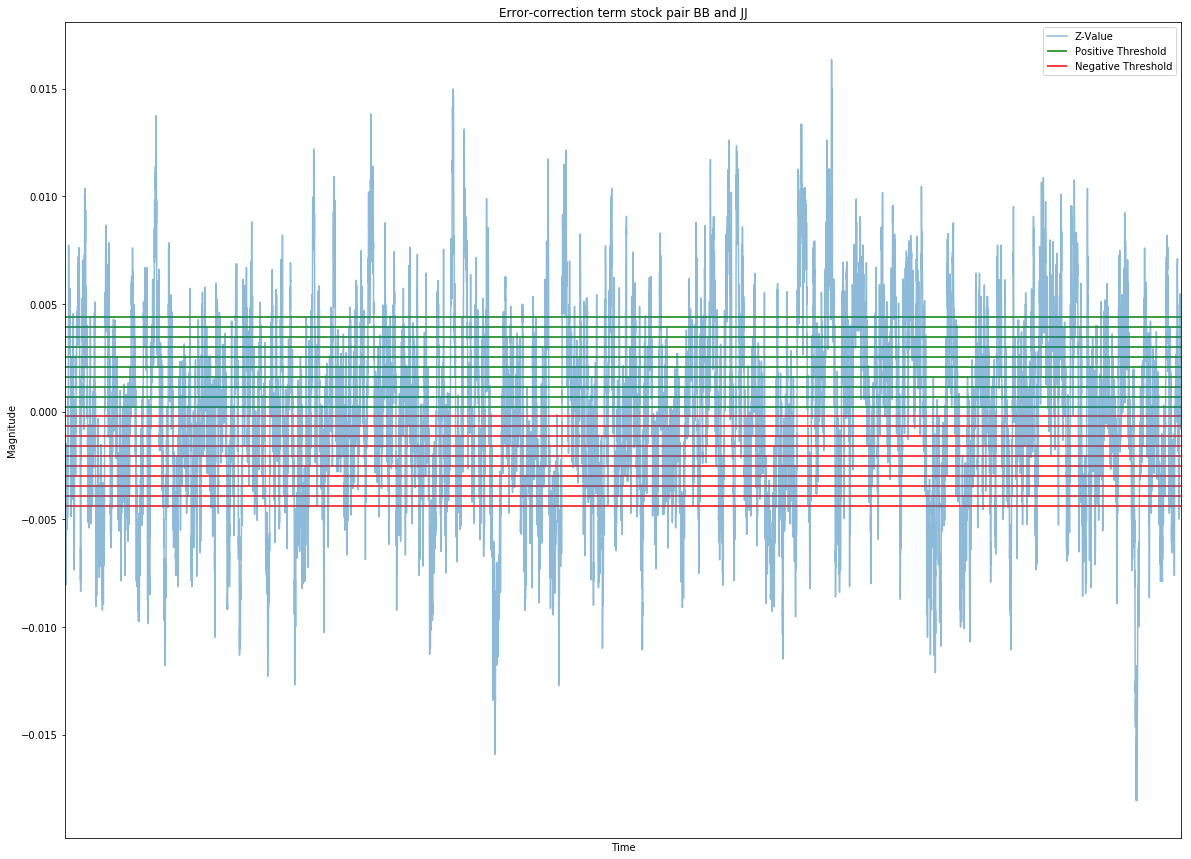

In [29]:
# Plot error-correction term (z-value) to observe what the spread looks like (see slide for comparison plot cointegrated pair)
def Plot_Thresholds(stock1, stock2):
    zvalue = tradable_pairs_data[stock1+stock2,'Z-Value']
    plt.figure(figsize=(20,15))
    plt.xticks([])
    plt.title('Error-correction term stock pair ' + stock1 + ' and ' + stock2)
    zvalue.plot(alpha=0.5)
    plt.xlabel('Time')
    plt.ylabel('Magnitude')
    xmin = 0
    xmax = len(zvalue)
    
    # Boundries chosen to give an approximate good fit
    plt.hlines(pnl_threshold['Thresholds'][10:20], xmin, xmax, 'g')  
    plt.hlines(-pnl_threshold['Thresholds'][10:20], xmin, xmax, 'r')
    
    plt.legend(['Z-Value', 'Positive Threshold', 'Negative Threshold'])
    plt.show()
        
Plot_Thresholds('BB','JJ')

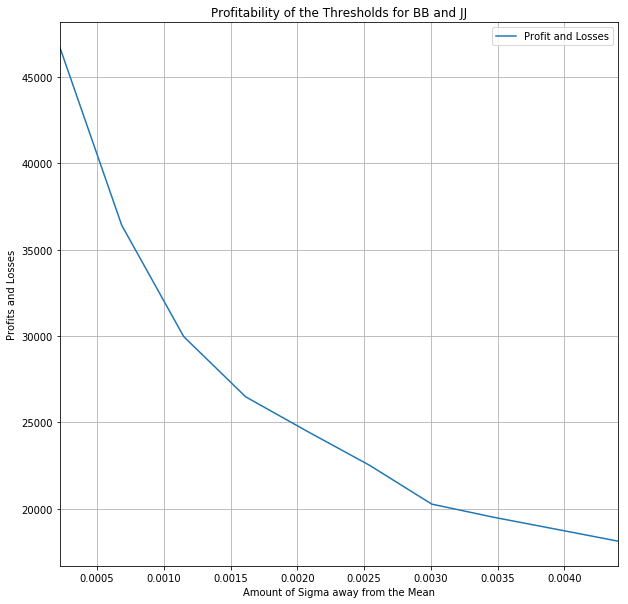

In [30]:
# Create a Plot that displays the Profitability of the Thresholds

def profitability_of_the_thresholds(stock1, stock2):
    pnl_threshold[(pnl_threshold.index == (stock1, stock2))].plot(x='Thresholds', y='PnLs', figsize=(10,10))
    plt.title('Profitability of the Thresholds for ' + stock1 + ' and ' + stock2)
    plt.xlabel('Amount of Sigma away from the Mean')
    plt.ylabel('Profits and Losses')
    plt.legend(['Profit and Losses'])
    plt.grid()

profitability_of_the_thresholds('BB','JJ')

# Algorithm Strategy 1

Making use of the previous analysis to determine which pairs should be traded. Based on that the algorithm, with slight modifications, is ran again to calculate the final profits.

In [31]:
# Determine the treshold, manually chosen based on pnl_threshold and ensuring no overlap.
threshold_dictionary = {('BB', 'JJ'): 0.000220,
                        ('FF', 'MM'): 0.000155,
                        ('DD', 'HH'): 0.000485,
                        ('AA', 'II'): 0.001070}

threshold_dictionary

{('BB', 'JJ'): 0.00022,
 ('FF', 'MM'): 0.000155,
 ('DD', 'HH'): 0.000485,
 ('AA', 'II'): 0.00107}

In [33]:
# Selection of the final pairs for this trading strategy
stock_pairs_final = [('BB', 'JJ'),
                     ('FF', 'MM'),
                     ('DD', 'HH'),
                     ('AA', 'II')]

stock_pairs_final

[('BB', 'JJ'), ('FF', 'MM'), ('DD', 'HH'), ('AA', 'II')]

This algorithm is a slight modification as the previous one used. In this algorithm we incorporate the chosen pairs, with the corresponding tresholds, to determine the most optimal positions.

In [34]:
positions_strategy_1 = {}
limit = 100

for pair in stock_pairs_final:
    stock1 = pair[0]
    stock2 = pair[1]
    
    gamma = gamma_dictionary[stock1,stock2]
    
    threshold = threshold_dictionary[stock1,stock2]
        
    current_position_stock1 = 0 
    current_position_stock2 = 0 
        
    positions_strategy_1[stock1] = []

    for time, data_at_time in tradable_pairs_data.iterrows():

        BidPrice_Stock1 = data_at_time[stock1, 'BidPrice']
        AskPrice_Stock1 = data_at_time[stock1, 'AskPrice']
        BidPrice_Stock2 = data_at_time[stock2, 'BidPrice']
        AskPrice_Stock2 = data_at_time[stock2, 'AskPrice']

        BidVolume_Stock1 = data_at_time[stock1, 'BidVolume']
        AskVolume_Stock1 = data_at_time[stock1, 'AskVolume']
        BidVolume_Stock2 = data_at_time[stock2, 'BidVolume']
        AskVolume_Stock2 = data_at_time[stock2, 'AskVolume']

        zvalue = data_at_time[stock1+stock2,'Z-Value']

        if zvalue >= threshold:
            hedge_ratio = gamma * (BidPrice_Stock1 / AskPrice_Stock2)
                
            if hedge_ratio >= 1:

                max_order_stock1 = current_position_stock1 + limit
                max_order_stock2 = max_order_stock1 / hedge_ratio

                trade = np.floor(min((BidVolume_Stock1 / hedge_ratio), AskVolume_Stock2, max_order_stock1, max_order_stock2))

                positions_strategy_1[stock1].append((- trade * hedge_ratio) + current_position_stock1)

                current_position_stock1 = ((- trade * hedge_ratio) + current_position_stock1)
                
            elif hedge_ratio < 1:

                max_order_stock1 = current_position_stock1 + limit
                max_order_stock2 = max_order_stock1 * hedge_ratio

                trade = np.floor(min((BidVolume_Stock1 * hedge_ratio), AskVolume_Stock2, max_order_stock1, max_order_stock2))

                positions_strategy_1[stock1].append((- trade / hedge_ratio) + current_position_stock1)

                current_position_stock1 = ((- trade / hedge_ratio) + current_position_stock1)

        elif zvalue <= -threshold:
            hedge_ratio = gamma * (AskPrice_Stock1 / BidPrice_Stock2)
                
            if hedge_ratio >= 1:

                max_order_stock1 = abs(current_position_stock1 - limit)
                max_order_stock2 = max_order_stock1 / hedge_ratio

                trade = np.floor(min((AskVolume_Stock1 / hedge_ratio), BidVolume_Stock2, max_order_stock1, max_order_stock2))

                positions_strategy_1[stock1].append((+ trade * hedge_ratio) + current_position_stock1)

                current_position_stock1 = (+ trade * hedge_ratio) + current_position_stock1

            elif hedge_ratio < 1:
                    
                max_order_stock1 = abs(current_position_stock1 - limit)
                max_order_stock2 = max_order_stock1 * hedge_ratio

                trade = np.floor(min((AskVolume_Stock1 * hedge_ratio), BidVolume_Stock2, max_order_stock1, max_order_stock2))

                positions_strategy_1[stock1].append((+ trade / hedge_ratio) + current_position_stock1)

                current_position_stock1 = (+ trade / hedge_ratio) + current_position_stock1   

        else:

                positions_strategy_1[stock1].append(current_position_stock1)
        
    if hedge_ratio >= 1:
        positions_strategy_1[stock2] = positions_strategy_1[stock1] / hedge_ratio * -1
        
    elif hedge_ratio < 1:
        positions_strategy_1[stock2] = positions_strategy_1[stock1] / (1 / hedge_ratio) * -1

In [35]:
# Set Ceiling (to prevent positions with not enough volume available) as well as define the timestamp
positions_strategy_1 = np.ceil(pd.DataFrame(positions_strategy_1))
positions_strategy_1['Timestamp'] = tradable_pairs_data.index
positions_strategy_1 = positions_strategy_1.set_index('Timestamp')

In [36]:
# The difference between the positions
positions_diff_strategy_1 = positions_strategy_1.diff()[1:]

# # Positions_diff first rows
# positions_diff_strategy_1.head()

In [37]:
#Used as mentioned earlier.
positions_diff_strategy_1[-1:] = -positions_strategy_1[-1:]

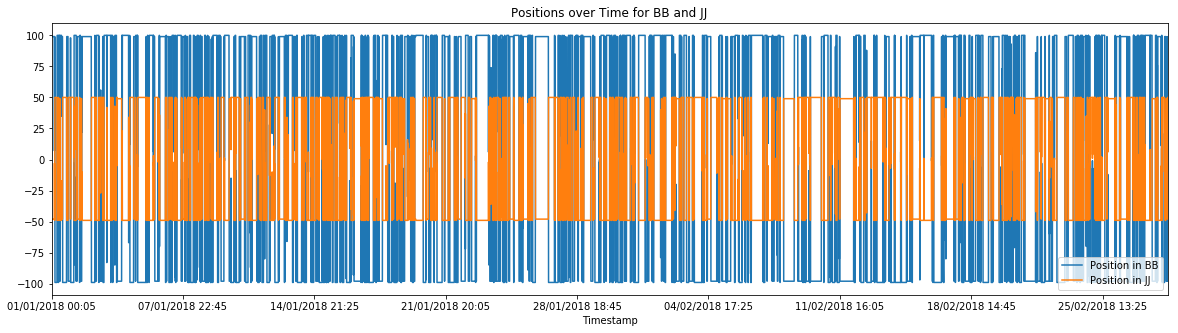

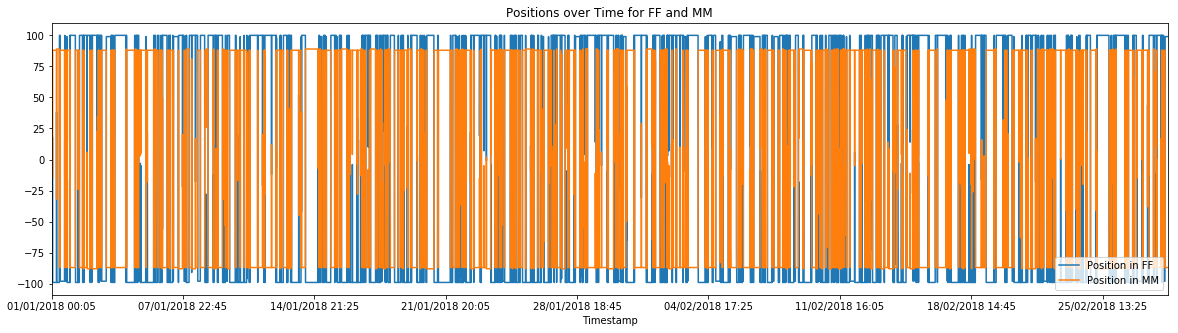

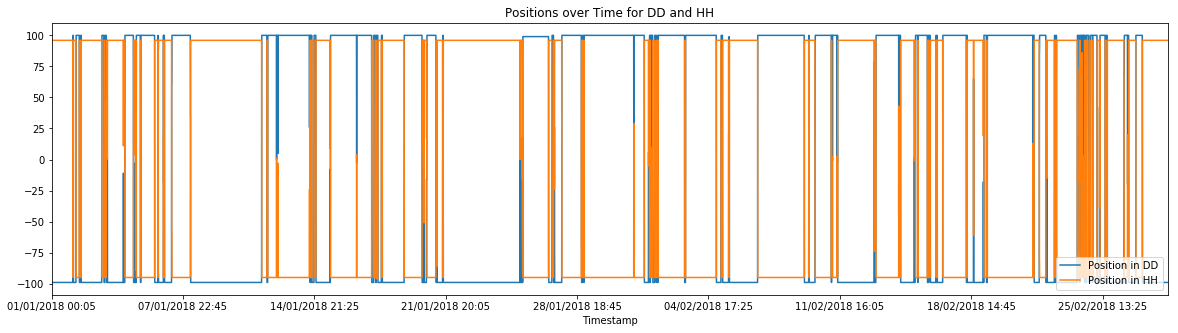

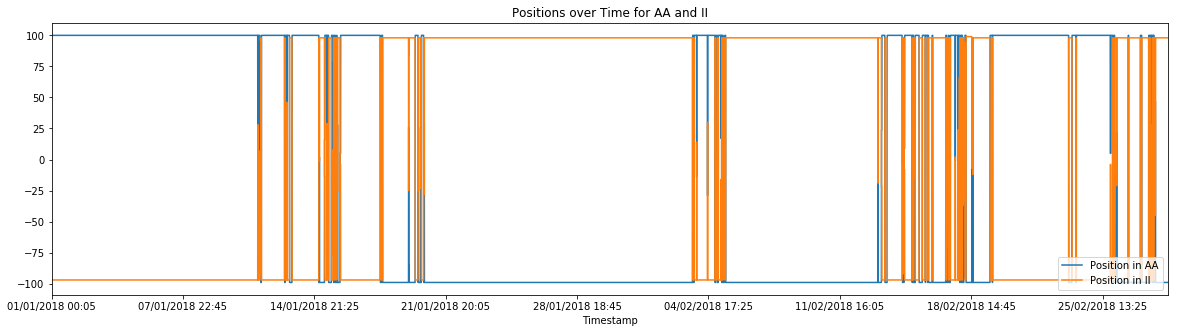

In [38]:
# Show Positions over Time
for pairs in stock_pairs_final:
    stock1 = pairs[0]
    stock2 = pairs[1]
    
    plt.figure(figsize=(20,5))
    
    positions_strategy_1[stock1].plot()
    positions_strategy_1[stock2].plot()
    
    plt.title('Positions over Time for ' + stock1 + ' and ' + stock2)
    plt.legend(["Position in " + stock1,"Position in " + stock2], loc='lower right')
    
    plt.show()

Re-run the PnL forloop to determine the profits. This could also be manually calculated with pnl_threshold values.

In [39]:
pnl_dataframe_strategy_1 = pd.DataFrame()

for pair in stock_pairs_final:
    stock1 = pair[0]
    stock2 = pair[1]
    
    Stock1_AskPrice = tradable_pairs_data[stock1,'AskPrice'][1:]
    Stock1_BidPrice = tradable_pairs_data[stock1,'BidPrice'][1:]
    Stock2_AskPrice = tradable_pairs_data[stock2,'AskPrice'][1:]
    Stock2_BidPrice = tradable_pairs_data[stock2,'BidPrice'][1:]

    pnl_dataframe_strategy_1[stock1] = np.where(positions_diff_strategy_1[stock1] > 0, positions_diff_strategy_1[stock1] * -Stock1_BidPrice, positions_diff_strategy_1[stock1] * -Stock1_AskPrice)
    pnl_dataframe_strategy_1[stock2] = np.where(positions_diff_strategy_1[stock2] > 0, positions_diff_strategy_1[stock2] * -Stock2_BidPrice, positions_diff_strategy_1[stock2] * -Stock2_AskPrice)

print("The total profit is: €",round(pnl_dataframe_strategy_1.sum().sum()))

The total profit is: € 135848.0


In [40]:
pnl_dataframe_strategy_1['Timestamp'] = tradable_pairs_data.index[1:]
pnl_dataframe_strategy_1 = pnl_dataframe_strategy_1.set_index('Timestamp')

pnl_dataframe_strategy_1['PnL'] = pnl_dataframe_strategy_1.sum(axis=1)
pnl_dataframe_strategy_1['Cum PnL'] = pnl_dataframe_strategy_1['PnL'].cumsum()

for pair in stock_pairs_final:
    stock1 = pair[0]
    stock2 = pair[1]

    pnl_dataframe_strategy_1[stock1+stock2 + ' PnL'] = pnl_dataframe_strategy_1[stock1] + pnl_dataframe_strategy_1[stock2]
    pnl_dataframe_strategy_1[stock1+stock2 + ' Cum PnL'] = pnl_dataframe_strategy_1[stock1+stock2 + ' PnL'].cumsum()

pnl_dataframe_strategy_1.tail()

,BB,JJ,FF,MM,DD,HH,AA,II,PnL,Cum PnL,BBJJ PnL,BBJJ Cum PnL,FFMM PnL,FFMM Cum PnL,DDHH PnL,DDHH Cum PnL,AAII PnL,AAII Cum PnL
Timestamp,,,,,,,,,,,,,,,,,,
28/02/2018 23:35,-7181.25,2861.95,-0.0,-0.00,-0.0,-0.0,-0.0,-0.0,-4319.30,124462.35,-4319.30,40830.20,-0.00,56565.05,-0.0,16309.3,-0.0,10757.8
28/02/2018 23:40,14880.00,-5932.85,-0.0,-0.00,-0.0,-0.0,-0.0,-0.0,8947.15,133409.50,8947.15,49777.35,-0.00,56565.05,-0.0,16309.3,-0.0,10757.8
28/02/2018 23:45,4032.00,-1615.95,-0.0,-0.00,-0.0,-0.0,-0.0,-0.0,2416.05,135825.55,2416.05,52193.40,-0.00,56565.05,-0.0,16309.3,-0.0,10757.8
28/02/2018 23:50,-0.00,-0.00,-0.0,-0.00,-0.0,-0.0,-0.0,-0.0,0.00,135825.55,-0.00,52193.40,-0.00,56565.05,-0.0,16309.3,-0.0,10757.8
28/02/2018 23:55,-9383.50,3862.50,10474.2,-7851.75,-11127.6,14371.2,-9187.2,8864.1,21.95,135847.50,-5521.00,46672.40,2622.45,59187.50,3243.6,19552.9,-323.1,10434.7


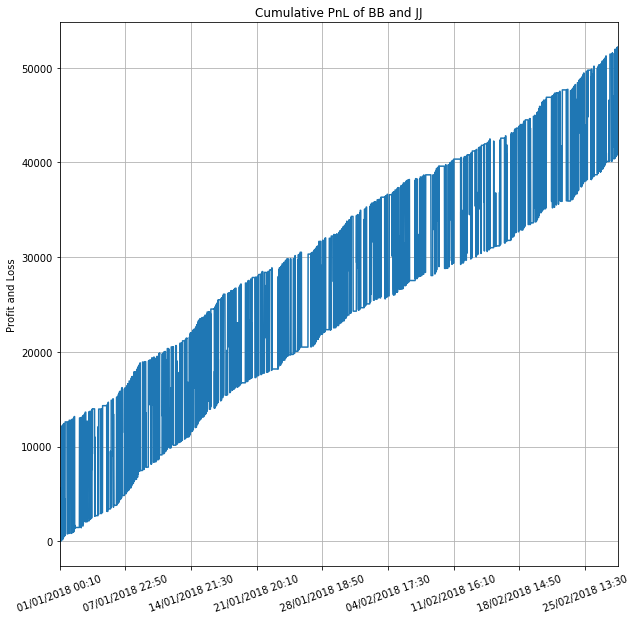

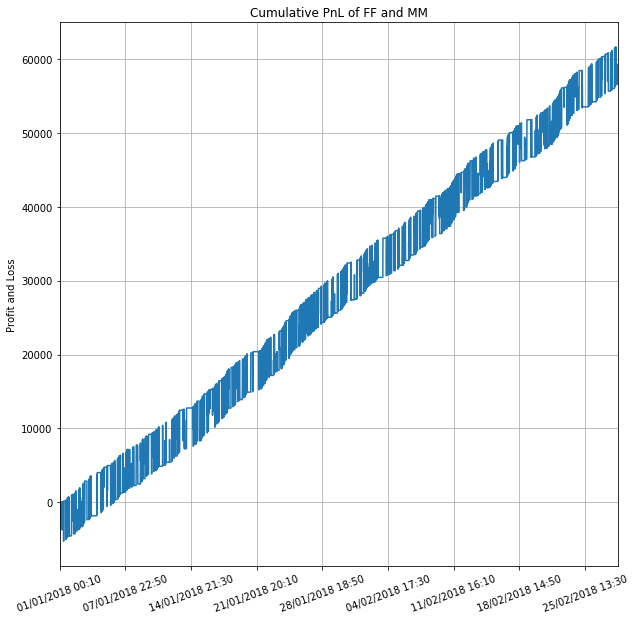

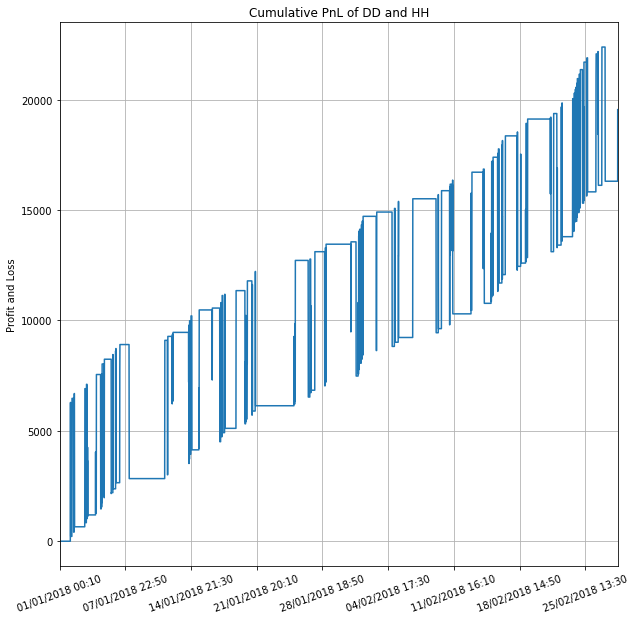

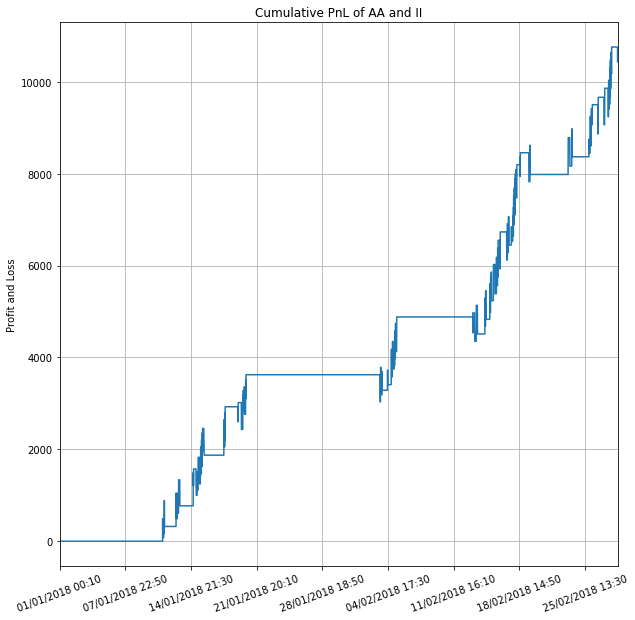

In [41]:
# All Pairs's PnL

for pair in stock_pairs_final:
    stock1 = pair[0]
    stock2 = pair[1]
    
    pnl_dataframe_strategy_1[stock1+stock2 + ' Cum PnL'].plot(figsize=(10,10))
    plt.title('Cumulative PnL of ' + stock1 + ' and ' + stock2)
    plt.ylabel('Profit and Loss')
    plt.xlabel("")
    plt.grid()
    plt.xticks(rotation=20)
    plt.show()


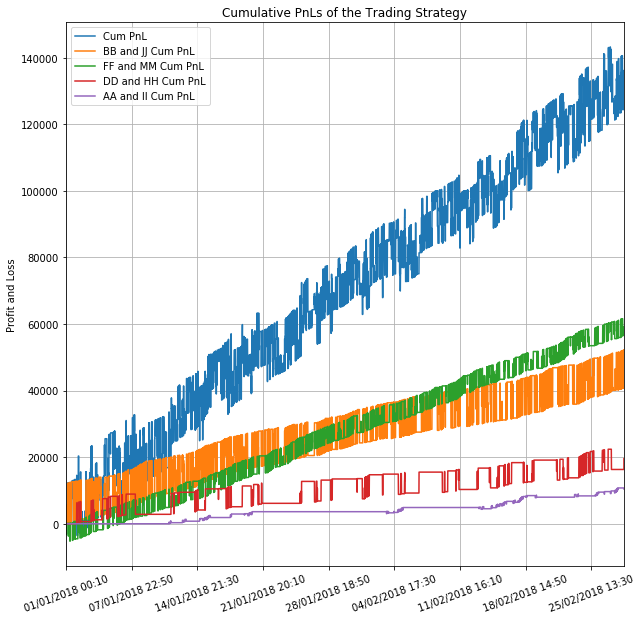

In [42]:
# All Pairs's PnLs (including total) in one graph

pnl_dataframe_strategy_1['Cum PnL'].plot()

for pair in stock_pairs_final:
    stock1 = pair[0]
    stock2 = pair[1]
    
    pnl_dataframe_strategy_1[stock1+stock2 + ' Cum PnL'].plot(figsize=(10,10))
    plt.legend(['Cum PnL', 'BB and JJ Cum PnL', 'FF and MM Cum PnL', 'DD and HH Cum PnL','AA and II Cum PnL'])
    plt.title('Cumulative PnLs of the Trading Strategy')
    plt.ylabel('Profit and Loss')
    plt.xlabel("")
    plt.grid()
    plt.xticks(rotation=20)

In [43]:
# Send to CSV
pnl_dataframe_strategy_1.to_csv('Algorithm PnL Results.csv')

In [44]:
# Send to Excel (in case CSV is incorrect)
pnl_dataframe_strategy_1.to_excel('Algorithm PnL Results.xlsx')

In [45]:
# # Our Theme Song for this Assignment, uncomment to run
# from IPython.display import HTML
# HTML('<iframe width="1000" height="315" src="https://www.youtube.com/embed/cOJtEvpSZhM?rel=0&amp;controls=0&amp;showinfo=0;autoplay=true" frameborder="0" allowfullscreen></iframe>')